In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

target_shape = (300, 300)

In [2]:
def preprocess_image(filename):
    """이미지를 읽고 data augmentation을 진행하는 함수"""
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    
    # 50%의 확률로 data augmentation을 하도록 정의
    if np.random.rand() > 0.5:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.2, 0.5)
        image = tf.image.random_saturation(image, 5, 10)
    return image


def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative)
    )

In [3]:
def load_pickle(filename):
    with open(filename, 'rb') as f:
        data: object = pickle.load(f)
    return data

In [4]:
# anchor_images, positive_images, negative_images 리스트 불러 오기
anchor_images = load_pickle('./data/anchor.pkl')
positive_images = load_pickle('./data/positive.pkl')
negative_images = load_pickle('./data/negative.pkl')
print(type(anchor_images), type(positive_images), type(negative_images))
print(len(anchor_images), len(positive_images), len(negative_images))

<class 'list'> <class 'list'> <class 'list'>
39000 39000 39000


In [5]:
data_path = './data/PlantVillage'

anchor_images = [os.path.join(data_path, f) for f in anchor_images]
positive_images = [os.path.join(data_path, f) for f in positive_images]
negative_images = [os.path.join(data_path, f) for f in negative_images]
print(anchor_images[:5])
image_count = len(anchor_images)
# anchor, positive, negative 이미지 별로 dataset 클래스를 생성함
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)  # data augmentation 적용

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

['./data/PlantVillage\\Apple___Apple_scab\\image (877).JPG', './data/PlantVillage\\Apple___Black_rot\\image (919).JPG', './data/PlantVillage\\Apple___Cedar_apple_rust\\image (337).JPG', './data/PlantVillage\\Apple___healthy\\image (413).JPG', './data/PlantVillage\\Background_without_leaves\\image (529).jpg']


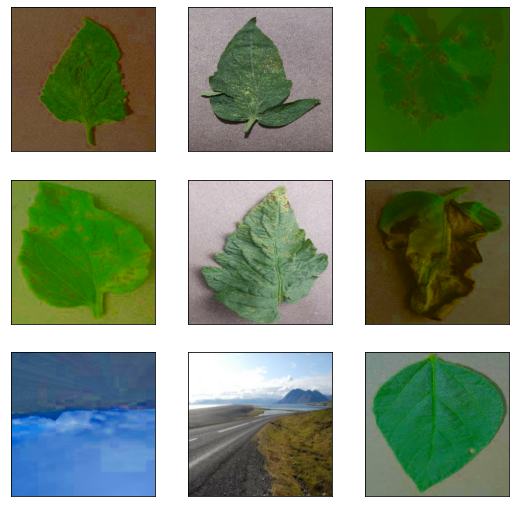

In [6]:
def visualize(anchor, positive, negative):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

# visualize 함수를 통해 data augmentation된 이미지 sample를 확인 할 수 있음        
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [7]:
# fine-tuning 대상인 feature extractor 정의
# 참고한 논문과 다르게 Inception V3 대신 ResNet 모델을 사용
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [8]:
# DistanceLayer라는 Custom Layer를 통해 triplet loss를 정의함
class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input))
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [9]:
class SiameseModel(Model):

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [10]:
# 모델을 25 epoch 훈련함
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=25, validation_data=val_dataset)

Epoch 1/25
975/975 [==============================] - 476s 473ms/step - loss: 0.3457 - val_loss: 0.2827
Epoch 2/25
975/975 [==============================] - 460s 472ms/step - loss: 0.2689 - val_loss: 0.2476
Epoch 3/25
975/975 [==============================] - 461s 473ms/step - loss: 0.2527 - val_loss: 0.2511
Epoch 4/25
975/975 [==============================] - 463s 475ms/step - loss: 0.2392 - val_loss: 0.2296
Epoch 5/25
975/975 [==============================] - 462s 474ms/step - loss: 0.2361 - val_loss: 0.2379
Epoch 6/25
975/975 [==============================] - 463s 475ms/step - loss: 0.2283 - val_loss: 0.2398
Epoch 7/25
975/975 [==============================] - 462s 474ms/step - loss: 0.2234 - val_loss: 0.2223
Epoch 8/25
975/975 [==============================] - 464s 476ms/step - loss: 0.2188 - val_loss: 0.2269
Epoch 9/25
975/975 [==============================] - 462s 474ms/step - loss: 0.2107 - val_loss: 0.2060
Epoch 10/25
975/975 [==============================] - 462s 474m

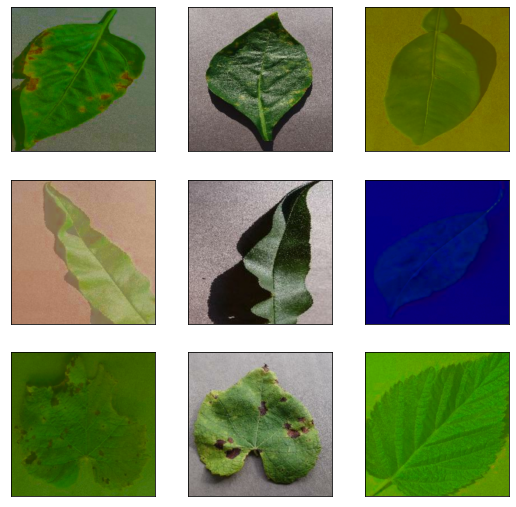

In [11]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative))
)

In [12]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity:", negative_similarity.numpy())

Positive similarity: 0.9999044
Negative similarity: 0.9998319


In [13]:
# 훈련한 모델을 특징 추출기로 사용하기 위해 모델을 저장해 
embedding.save("embeddings/embeddings_e25_v1")

C:\Users\user\.conda\envs\tf2_5\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: embeddings/embeddings_e25_v1\assets
